# Nigeria

## Calculate and visualize average food consumption across Nigeria
The data below is from the Nigeria General Household Survey - Wave 3 (2015-2016). It's [available](http://microdata.worldbank.org/index.php/catalog/2936/datafile/F11) on the WB Microdata Library.

With household survey data, sample weights are important to generalize from the sample to the population.

- **Objective: Calculate and visualize average food consumption across Nigeria's regions**

In [195]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
import pylab as plt
%pylab inline
import seaborn as sns
import mplleaflet as mpll
import osmnx as ox
from IPython.display import Image
import matplotlib.pyplot as plt2

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


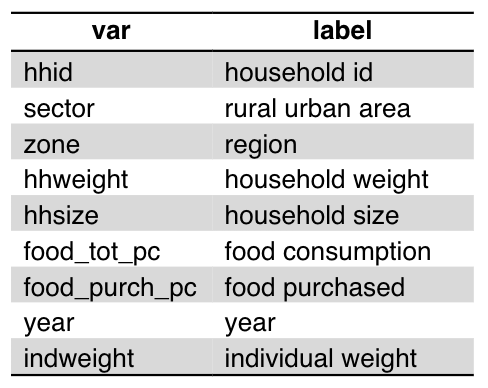

In [3]:
from IPython.display import Image
Image('data/nigeria_table.png', width = 250)

In [5]:
df2 = pd.read_csv('data/food2_pc.csv')

df2.rename(columns = {'hhweight':'household_weight','hhsize':'household_size','food_tot_pc':'food_consumption_pc',
           'food_purch_pc':'food_purchased_pc','indweight':'individual_weight'}, inplace=True)

df2.sector.replace({'1. URBAN': 'urban', '2. RURAL':'rural'}, inplace=True)
df2.zone.replace({'4. SOUTH EAST':'south_east', '2. NORTH EAST':'north_east', '5. SOUTH SOUTH':'south_south',
       '1. NORTH CENTRAL':'north_central', '6. SOUTH WEST':'south_west', '3. NORTH WEST':'north_west'}, inplace = True)

In [6]:
df2.head()

,hhid,sector,zone,household_weight,household_size,food_consumption_pc,food_purchased_pc,year,individual_weight
0,10001,urban,south_east,11898.656886,6,66134.52,66134.52,2016,71391.94
1,10002,urban,south_east,11898.656886,5,154360.40,154360.40,2016,59493.29
2,10003,urban,south_east,11898.656886,6,72695.84,72465.79,2016,71391.94
3,10004,urban,south_east,11898.656886,4,90533.04,90533.04,2016,47594.63
4,10005,urban,south_east,11898.656886,7,59554.59,59357.41,2016,83290.60


#### 1. Inspect data and remove outliers

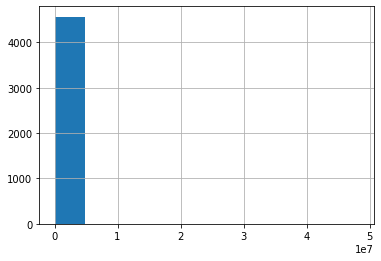

In [7]:
df2.food_consumption_pc.hist()

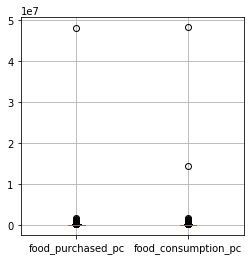

In [8]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

In [9]:
print(df2.food_purchased_pc.max())
print(df2.food_purchased_pc.mean())

48200000.0
71520.49595792302


In [10]:
# Remove observations more than 3 standard deviations above the mean

df2['food_purchased_pc'][df2['food_purchased_pc'] > (df2.food_purchased_pc.mean()
                                                     + df2.food_purchased_pc.std() * 3)] = np.nan
df2['food_consumption_pc'][df2['food_consumption_pc'] > (df2.food_consumption_pc.mean() 
                                                         + df2.food_consumption_pc.std() * 3)] = np.nan
df2.dropna(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
print(df2.food_purchased_pc.max())
print(df2.food_purchased_pc.mean())

1788152.0
60952.09905321461


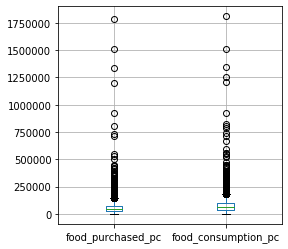

In [12]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

#### 2. Calculate mean food consumption by region, and by rural / urban.

The Pandas groupby function makes this easy. It does three things:
* Split the data into groups.
* Apply a function to each group independently (eg. sum, mean, counts).
* Combine the results into a data structure.

In [13]:
df2.groupby(['zone'])['food_consumption_pc'].mean()

zone
north_central     68276.045109
north_east        62701.572977
north_west        55262.463779
south_east        93867.487344
south_south      117532.042266
south_west        90956.257569
Name: food_consumption_pc, dtype: float64

We plotted mean food consumption among 5000 surveyed households; doesn't represent population as a whole!

#### 3. Calculate mean food consumption for population

Weighted mean:

$$\overline x = \frac{\sum wx}{\sum w}$$

ie. sum of values times weights / sum of weights

In [15]:
sum(df2.food_purchased_pc * df2.individual_weight) / df2.household_weight.sum()

289663.4699519813

In [17]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [18]:
weighted_mean(values = df2.food_purchased_pc[df2.zone == 'south_east'],
             weights = df2.household_weight[df2.zone == 'south_east'])

73451.24198885933

The weighted mean for South East is 73,451 whereas the simple mean food consumption is misleadingly 93,867. So let us produce weighted means for all regions

In [19]:
weighted_means_table = pd.Series({zone: weighted_mean(df2.food_consumption_pc[df2.zone == zone],
                                  df2.household_weight[df2.zone == zone]) for zone in df2.zone.unique()},
                                name = 'mean_food_consumption_pc')

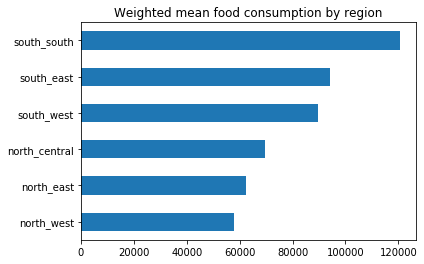

In [21]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Weighted mean food consumption by region');

#### 4. Visualize on a map of Nigeria
* A good data source is GADM, which has admin boundaries for all countries at levels 0 through 3 (national boundaries through to ward level). https://gadm.org/


* GADM1 gives us Nigeria's 36 states and capital territory. Our dataset uses the six [Geopolitical Zones](https://en.wikipedia.org/wiki/Geopolitical_zones_of_Nigeria) of Nigeria instead (these each comprise about 5-8 states). Create the required polygons by aggregating the state boundaries using Geopandas [dissolve](http://geopandas.org/aggregation_with_dissolve.html) function.

In [22]:
nigeria_GADM = gpd.read_file('data/nigeria/gadm36_NGA_1.shp')

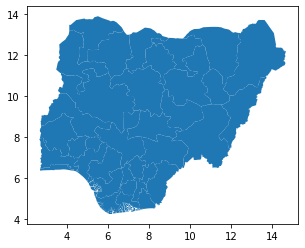

In [23]:
nigeria_GADM.plot()

Ensure the region names in our data match those in the GADM shapefile

In [28]:
north_central = ['Benue','Kogi','Kwara', 'Nassarawa', 'Niger','Plateau', 'Federal Capital Territory']
north_east = ['Adamawa', 'Bauchi', 'Borno', 'Gombe', 'Taraba', 'Yobe']
north_west = ['Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Sokoto', 'Zamfara']
south_east = ['Abia', 'Anambra', 'Ebonyi', 'Enugu', 'Imo']
south_south = ['Akwa Ibom', 'Bayelsa', 'Cross River', 'Rivers', 'Delta', 'Edo']
south_west = ['Ekiti', 'Lagos', 'Ogun', 'Ondo', 'Osun', 'Oyo']

def remap_states(state):
    if state in north_east:
        return('north_east')
    elif state in north_central:
        return('north_central')
    elif state in north_west:
        return('north_west')
    elif state in south_east:
        return('south_east')
    elif state in south_south:
        return('south_south')
    elif state in south_west:
        return('south_west')
    else:
        return('error!')

A quick way to transform the rows or columns of a DataFrame is df.apply(). This runs a function of your choice across all the rows (axis = 0, the default) or all the columns (axis = 1).

In [29]:
nigeria_GADM.head(2)

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB,"POLYGON ((7.48997593 4.85505676, 7.49437714 4...."
1,NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD,"POLYGON ((12.01237392 7.50763273, 12.00726032 ..."


In [30]:
nigeria_GADM['region'] = nigeria_GADM.NAME_1.apply(remap_states)

In [31]:
# Create a new geodataframe comprising six merged polygons

regions = nigeria_GADM.dissolve(by = 'region')

In [36]:
regions.head(10) # this calls for the first 10 but we get 6 because there are 6 regions

,geometry,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
region,,,,,,,,,,,
north_central,"POLYGON ((7.82773113 6.63026714, 7.82988024 6....",NGA,Nigeria,NGA.7_1,Benue,None,None,State,State,None,NG.BE
north_east,"POLYGON ((10.1536665 7.03837299, 10.15335178 7...",NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD
north_west,"POLYGON ((5.43651819 11.02907562, 5.43641996 1...",NGA,Nigeria,NGA.18_1,Jigawa,None,None,State,State,None,NG.JI
south_east,"POLYGON ((7.48997593 4.85505676, 7.49437714 4....",NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB
south_south,"(POLYGON ((6.58263922 4.67208385, 6.58263922 4...",NGA,Nigeria,NGA.3_1,Akwa Ibom,None,None,State,State,None,NG.AK
south_west,"(POLYGON ((4.99680519 5.86319399, 4.99680519 5...",NGA,Nigeria,NGA.13_1,Ekiti,None,None,State,State,None,NG.EK


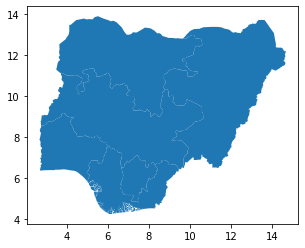

In [33]:
regions.plot()

In [34]:
# Check the two frames have the same length before merging

regions.shape

(6, 11)

In [37]:
weighted_means_table.shape

(6,)

In [38]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [39]:
regions_merged = gpd.GeoDataFrame(regions_merged)

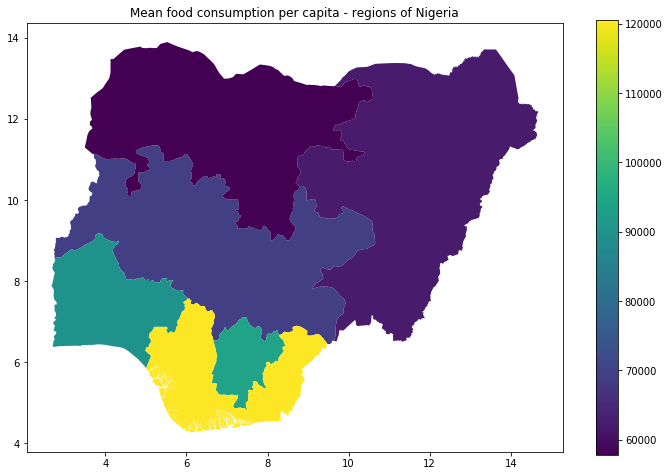

In [40]:
regions_merged.plot(column = 'mean_food_consumption_pc', legend = True, figsize = [12,8])
plt.title('Mean food consumption per capita - regions of Nigeria');

# Zimbabwe


## Zimbabwe enterprise surveys

The data below is from the Nigeria General Household Survey - Wave 3 (2015-2016). It's [available](http://microdata.worldbank.org/index.php/catalog/2936/datafile/F11) on the WB Microdata Library.

With household survey data, sample weights are important to generalize from the sample to the population.

- **Objective: Calculate and visualize average food consumption across Nigeria's regions**

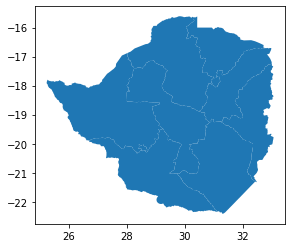

In [48]:
zimbabwe_GADM = gpd.read_file('data/zimbabwe/gadm36_ZWE_1.shp')
zimbabwe_GADM.plot()

In [50]:
zimbabwe_GADM.head(2)

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,ZWE,Zimbabwe,ZWE.1_1,Bulawayo,None,None,City,City,None,ZW.BU,"POLYGON ((28.61305046 -20.23587036, 28.6044006..."
1,ZWE,Zimbabwe,ZWE.2_1,Harare,None,None,City,City,None,ZW.HA,"POLYGON ((31.08852005 -17.66624832, 31.1103801..."


In [56]:
# List GADM regions for Zimbabwe
zimbabwe_GADM['NAME_1'].value_counts()

Mashonaland West       1
Matabeleland South     1
Mashonaland East       1
Masvingo               1
Harare                 1
Manicaland             1
Midlands               1
Bulawayo               1
Matabeleland North     1
Mashonaland Central    1
Name: NAME_1, dtype: int64

## Ghana enterprise surveys

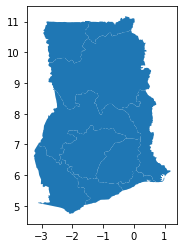

In [61]:
ghana_GADM = gpd.read_file('data/ghana/gadm36_GHA_1.shp')
ghana_GADM.plot()

In [62]:
ghana_GADM.shape

(10, 11)

In [58]:
# List Ghana regions on GADM
ghana_GADM['NAME_1'].value_counts()

Central          1
Volta            1
Upper East       1
Greater Accra    1
Ashanti          1
Upper West       1
Western          1
Eastern          1
Brong Ahafo      1
Northern         1
Name: NAME_1, dtype: int64

## Botswana enterprise surveys

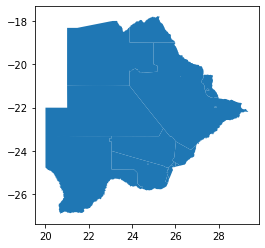

In [41]:
botswana_GADM = gpd.read_file('data/botswana/gadm36_BWA_1.shp')
botswana_GADM.plot()

In [64]:
# List Botswana regions on GADM
botswana_GADM['NAME_1'].value_counts()

Kgatleng         1
Ghanzi           1
South-East       1
North-West       1
Kweneng          1
Jwaneng          1
Gaborone         1
Kgalagadi        1
Southern         1
Central          1
Chobe            1
Selibe Phikwe    1
Lobatse          1
North-East       1
Francistown      1
Sowa             1
Name: NAME_1, dtype: int64

## Malaysia enterprise surveys

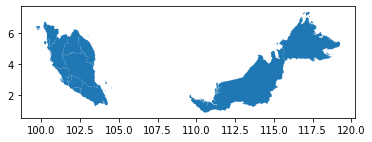

In [141]:
malaysia_GADM = gpd.read_file('data/malaysia/gadm36_MYS_1.shp')
malaysia_GADM.plot()

In [142]:
# List MYS regions on GADM
malaysia_GADM['NAME_1'].value_counts()

Kedah              1
Selangor           1
Perak              1
Negeri Sembilan    1
Sarawak            1
Trengganu          1
Melaka             1
Johor              1
Labuan             1
Pulau Pinang       1
Kuala Lumpur       1
Putrajaya          1
Perlis             1
Kelantan           1
Pahang             1
Sabah              1
Name: NAME_1, dtype: int64

In [143]:
East_Malaysia = ['Sarawak','Labuan','Sabah']
North = ['Kedah', 'Perak', 'Pulau Pinang', 'Perlis']
East_Coast = ['Trengganu', 'Kelantan', 'Pahang']
South = ['Johor']
Central = ['Selangor', 'Negeri Sembilan', 'Kuala Lumpur', 'Putrajaya', 'Melaka']

def remap_mystates(region):
    if region in East_Malaysia:
        return('East Malaysia')
    elif region in North:
        return('North')
    elif region in East_Coast:
        return('East Coast')
    elif region in South:
        return('South')
    elif region in Central:
        return('Central')
    else:
        return('error!')

In [144]:
df_my = pd.read_csv('data/malaysia/MYS_ES_2016.csv')
df_my.head()

,region,size,own_domestic,own_foreign,own_gov,own_other,year_estab,weight,ageofbiz
0,East Malaysia,Small,40,0,0,60,2014,97.214439,1
1,North,Medium,70,30,0,0,2014,66.450867,2
2,East Coast,Medium,100,0,0,0,2013,184.729750,2
3,East Coast,Medium,100,0,0,0,2013,5.526067,2
4,East Coast,Medium,100,0,0,0,2013,5.526067,2


In [145]:
df_my.rename(columns = {'own_domestic':'share_dom','own_foreign':'share_foreign','own_gov':'share_govt'}, inplace=True)

In [146]:
df_my.head()

,region,size,share_dom,share_foreign,share_govt,own_other,year_estab,weight,ageofbiz
0,East Malaysia,Small,40,0,0,60,2014,97.214439,1
1,North,Medium,70,30,0,0,2014,66.450867,2
2,East Coast,Medium,100,0,0,0,2013,184.729750,2
3,East Coast,Medium,100,0,0,0,2013,5.526067,2
4,East Coast,Medium,100,0,0,0,2013,5.526067,2


#### 1. Inspect data and remove outliers

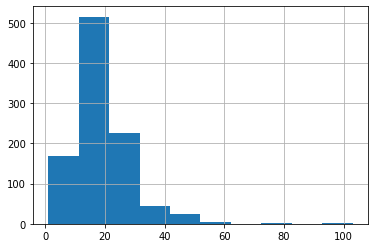

In [147]:
# view the distribution of the age of firms
df_my.ageofbiz.hist() 

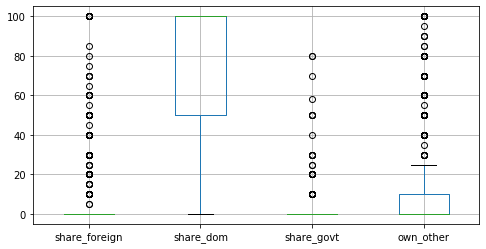

In [148]:
# view box plots of ownership shares by type
df_my[['share_foreign', 'share_dom', 'share_govt', 'own_other']].boxplot(figsize = [8,4])

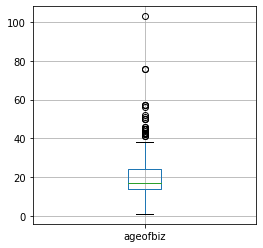

In [149]:
# view box plots of age
df_my[['ageofbiz']].boxplot(figsize = [4,4])

In [150]:
print("Oldest establishment in sample: ", df_my.ageofbiz.max())
print("The average (mean) age is: ", df_my.ageofbiz.mean())
print("The average (median) age is: ", df_my.ageofbiz.median())

Oldest establishment in sample:  103
The average (mean) age is:  19.196138211382113
The average (median) age is:  17.0


In [151]:
# Remove observations more than 3 standard deviations above the mean age
df_my['ageofbiz'][df_my['ageofbiz'] > (df_my.ageofbiz.mean()
                                                     + df_my.ageofbiz.std() * 3)] = np.nan
df_my.dropna(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


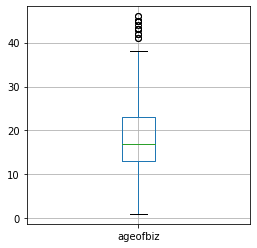

In [152]:
# view box plots of age again
df_my[['ageofbiz']].boxplot(figsize = [4,4])

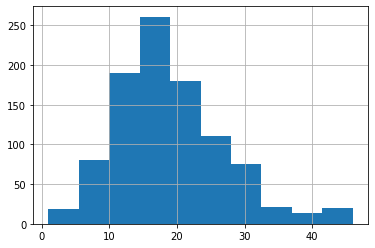

In [153]:
# view the distribution of the age of firms again - the distribution is now more normal
df_my.ageofbiz.hist()

#### 2. Calculate mean age of establishment by region and size.

The Pandas groupby function makes this easy. It does three things:
* Split the data into groups.
* Applie a function to each group independently (eg. sum, mean, counts).
* Combine the results into a data structure.

In [154]:
df_my.groupby(['region'])['ageofbiz'].mean()

region
Central          17.956204
East Coast       19.046980
East Malaysia    20.170213
North            19.913462
South            17.050000
Name: ageofbiz, dtype: float64

In [155]:
df_my.groupby(['size'])['ageofbiz'].mean()

size
Large     21.228873
Medium    18.306709
Small     17.053333
Name: ageofbiz, dtype: float64

#### Use sample weights to get representative estimates

In [156]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [157]:
weighted_mean(values = df_my.ageofbiz[df_my.region == 'Central'],
             weights = df_my.weight[df_my.region == 'Central'])

15.388496842942706

In [158]:
weighted_means_table = pd.Series({region: weighted_mean(df_my.ageofbiz[df_my.region == region],
                                  df_my.weight[df_my.region == region]) for region in df_my.region.unique()},
                                name = 'mean_ageofbiz')

In [159]:
weighted_means_table.head()

East Malaysia    17.978777
North            20.542607
East Coast       13.634069
South            13.059007
Central          15.388497
Name: mean_ageofbiz, dtype: float64

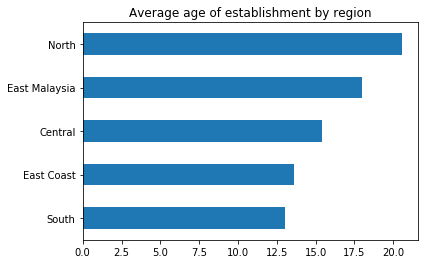

In [160]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Average age of establishment by region');

In [161]:
malaysia_GADM['region'] = malaysia_GADM.NAME_1.apply(remap_mystates)

In [162]:
# Create a new geodataframe comprising merged polygons

regions = malaysia_GADM.dissolve(by = 'region')

In [163]:
regions.head(20)

,geometry,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
region,,,,,,,,,,,
Central,"(POLYGON ((102.33499908 2.04833293, 102.335281...",MYS,Malaysia,MYS.4_1,Kuala Lumpur,Federal Territory of Kuala Lumpur,None,Wilayah Persekutuan,Federal Territory,None,MY.KL
East Coast,"(POLYGON ((103.45878601 3.4653151, 103.4582290...",MYS,Malaysia,MYS.3_1,Kelantan,<Null>,None,Negeri,State,None,MY.KN
East Malaysia,"(POLYGON ((118.62939453 4.11226416, 118.629058...",MYS,Malaysia,MYS.5_1,Labuan,Federal Territory of Labuan,None,Wilayah Persekutuan,Federal Territory,None,MY.LA
North,"(POLYGON ((100.10290527 3.97631788, 100.102996...",MYS,Malaysia,MYS.2_1,Kedah,Kedah Darul Aman,None,Negeri,State,None,MY.KH
South,"(POLYGON ((104.11413574 2.17112207, 104.113540...",MYS,Malaysia,MYS.1_1,Johor,Johor Darul Takzim|Johore,None,Negeri,State,None,MY.JH


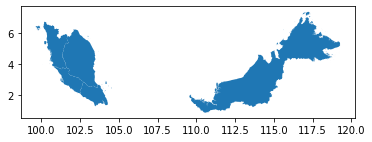

In [164]:
regions.plot()

In [165]:
regions.shape

(5, 11)

In [166]:
weighted_means_table.shape

(5,)

In [167]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [168]:
regions_merged = gpd.GeoDataFrame(regions_merged)

In [187]:
description=print("Source: Own analysis of data from the World Bank's Enterprise Survey, 2016")

Source: Own analysis of data from the World Bank's Enterprise Survey, 2016


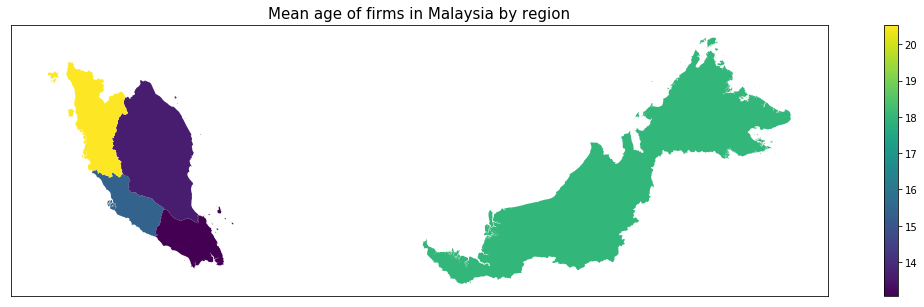

In [231]:
regions_merged.plot(column = 'mean_ageofbiz', legend = True, figsize = [20,5])
plt.title('Mean age of firms in Malaysia by region', fontdict={'fontsize': 15});
plt.xticks([])
plt.yticks([])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  """


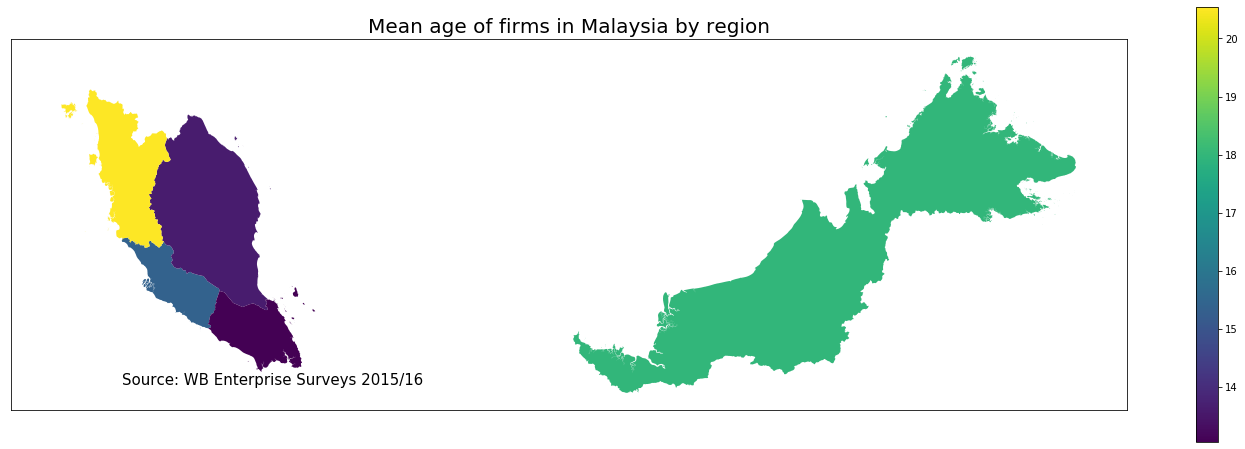

In [218]:
regions_merged.plot(column = 'mean_ageofbiz', legend = True, figsize = [25,8])
plt2.title('Mean age of firms in Malaysia by region', fontdict={'fontsize': 20});
plt2.xticks([])
plt2.yticks([])
plt2.annotate('Source: WB Enterprise Surveys 2015/16', xy=(0.1, 0.1), size=15, xycoords='axes fraction', textcoords='offset points', va='top')
plt2.gca().axes.get_yaxis().set_visible(False)
plt2.show()